# Preamble

In [5]:
# imports
import autograd.numpy as npa
import numpy as np
import matplotlib.pylab as plt

from autograd.extend import defjvp, defvjp
from scipy.linalg import dft

import sys
sys.path.append('../ceviche')

from ceviche import fdtd, jacobian
from ceviche.utils import my_fft
%matplotlib inline

# Autograd through spectrum computation

### Parameters

In [6]:
#
Nx = 50
Ny = 50
Nz = 1

npml = 10

omega = 2*np.pi*200e12
dL = 5e-8
pml = [npml, npml, 0]

# source parameters
sigma = 10e-15
total_time = 0.5e-12
t0 = sigma * 10

source_amp = 1
source_pos = np.zeros((Nx, Ny, Nz))
source_pos[npml+10, Ny//2, Nz//2] = source_amp

# starting relative permittivity (random for debugging)
eps_r   = np.random.random((Nx, Ny, Nz)) + 1
F = fdtd(eps_r, dL=dL, npml=pml)
dt = F.dt

steps = int(total_time / dt)
print('{} time steps'.format(steps))

gaussian = lambda t: source_amp * np.exp(-(t - t0 / dt)**2 / 2 / (sigma / dt)**2)
source = lambda t: source_pos * gaussian(t) * np.cos(omega * t * dt)

measure_pos = np.zeros((Nx, Ny, Nz))
measure_pos[-npml-10, Ny//2, Nz//2] = 1

10385 time steps


### Plot source

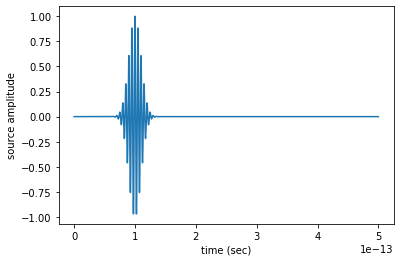

In [7]:
#
plt.plot(dt * np.arange(steps), np.sum(source(np.arange(steps)), axis=(0,1)))
plt.xlabel('time (sec)')
plt.ylabel('source amplitude')
plt.show()

### Define objective

In [8]:
def objective(eps_space):
    F.eps_r *= eps_space
    measured = []
    for t_index in range(steps):
        fields = F.forward(Jz=source(t_index))
        measured.append(npa.sum(fields['Ez'] * measure_pos))
    measured_f = my_fft(npa.array(measured))
    spectral_power = npa.square(npa.abs(measured_f))
    return spectral_power

### Calculate Jacobian

In [9]:
eps_space = 1.0
spectral_power = objective(eps_space)
jac_power = jacobian(objective, mode='forward')(eps_space)
jac_power_num = jacobian(objective, mode='numerical')(eps_space)

### Plot results

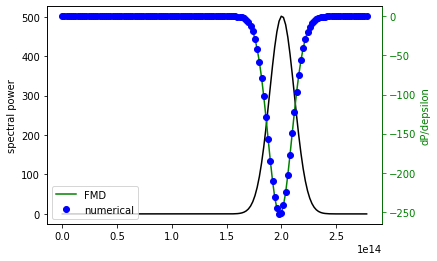

In [10]:
n_disp = 140

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
delta_f = 1 / steps / dt
freq_x = np.arange(n_disp) * delta_f
ax1.plot(freq_x, spectral_power[:n_disp], 'k-')
ax2.plot(freq_x, jac_power[:n_disp,0], 'g-', label='FMD')
ax2.plot(freq_x, jac_power_num[:n_disp,0], 'bo', label='numerical')
ax1.set_ylabel('spectral power', color='k')
ax2.set_ylabel('dP/depsilon', color='g')
ax2.spines['right'].set_color('g')
ax2.legend()
ax2.tick_params(axis='y', colors='g')
plt.show()